### Imports

In [143]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand
from scipy.io import loadmat
import time
from functools import wraps
import picos as pc
import sympy as sym
plt.style.use("default")

### Runtime

In [144]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [145]:
# Note that there are several shapes in the LASA Handwriting dataset

name_of_dataset = 'Angle'
#name_of_dataset = 'CShape'
#name_of_dataset = 'GShape'
#name_of_dataset = 'JShape'
# name_of_dataset = 'Sshape'
#name_of_dataset = 'Worm'

dataset = loadmat("../Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

#### Mean of dataset

In [147]:
num_of_train_datasets = 4
#init_position_of_demos = np.zeros((size_of_state, num_of_train_datasets))

pos_cell_1 = np.zeros((1000, num_of_train_datasets))
pos_cell_2 = np.zeros((1000, num_of_train_datasets))
vel_cell_1 = np.zeros((1000, num_of_train_datasets))
vel_cell_2 = np.zeros((1000, num_of_train_datasets))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file
    #init_position_of_demos[:,i] = position_dataseries[:,0]

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1) # computes the mean across each columns
x_train_2 = pos_cell_2.mean(axis=1) # computes the mean across each columns
y_train_1 = vel_cell_1.mean(axis=1) # computes the mean across each columns
y_train_2 = vel_cell_2.mean(axis=1)

x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0] # good

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1] 

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1) # axis = 1 is to concatenate at the second dimension
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
#init_condition = stat.mean(init_position_of_demos[1]) # Average starting point of all demos
num_of_test_datasets = num_of_demos - num_of_train_datasets
init_position_of_test_demo = np.zeros((size_of_state, num_of_test_datasets))
#init_condition = init_position_of_demos.mean(axis=1) # computes the mean across each column
#init_condition = dataset['demos'][0,5][0,0][0][:, 0]

for i in range(0, num_of_test_datasets):
    init_position_of_test_demo[:, i] = dataset['demos'][0,i+num_of_train_datasets][0,0][0][:, 0]

print(init_position_of_test_demo)
init_condition = init_position_of_test_demo.mean(axis=1)
print(init_condition)

# init_condition = init_position_of_demos[5:7].mean(axis=1) # Kan brukes tror jeg hvis init_position_of_demos er alle 7 kolonner


[[-47.5862069  -46.89655172 -48.96551724]
 [  2.06896552   0.68965517  -1.72413793]]
[-47.81609195   0.34482759]


#### Plot dataset (state trajectory with velocities as arrows)

C:\Users\Heli\AppData\Local\Temp\ipykernel_5552\1901655976.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


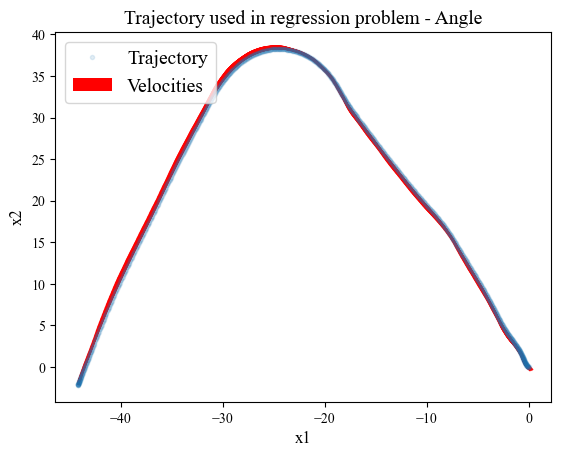

In [148]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.', alpha = 0.12)
plt.quiver(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:], color = 'red', scale = 700)
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Velocities'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_dataset.show()
#plt.savefig("../src/figures_plot/lasa_datatset.eps", format ="eps")

axes = plt.gca() #gca = get current axes, from my last plot

### From notebook: vector_valued_with_rff

In [149]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

#### Psi derivative

In [150]:
def psi_derivative(x, w, b):
    return np.sqrt(2) * (-np.sin(w.T@x + b)) * w

#### Finding alpha without constraint

In [151]:
def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    #alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_param', (m_param*dim_param, 1))
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    #alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

#### Alpha with contraction constraint

In [152]:
def alpha_approx_with_constraint(x_vector, y, dim, m, lam, n, mu, const_points):
    phi_ = phi(x_vector, w, b, n, m, dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    mu_param = pc.Constant('mu', mu)
    constraint_points = pc.Constant('const_points', const_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (m_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points):
        x = x_vector[:, i*4]
        gradient = np.zeros(dim)
        for j in range(m):
            index = 2*j
            psi_derivative_param = pc.Constant('psi_derivative', psi_derivative(x, w[:, j], b[:, j]))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

### Random Fourier Features & Regression

In [153]:
sigma = 10
lambda_ = 0.1
num_of_contraction_points = 250
num_of_samples = 100

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

# Random Fourier features approx
mu = 0.0

""" alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)
print(alpha_array_rff.shape) """

alpha_array_rff = alpha_approx_with_constraint(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_contraction_points)

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func

# learnt_model as lambda function
#F = lambda t, x: capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff

#### Solve diff. equation using learnt model w. solver_ivp

In [154]:
timespan = np.array([time_series[0],time_series[-1]])
t = np.linspace(time_series[0],time_series[-1], 1000)
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t).y

### Plot simulated trajectory and streamslices for learnt model

In [155]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):
    # get velocities at each point with the learnt model
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

#### Combined solution and vector field for learnt model

C:\Users\Heli\AppData\Local\Temp\ipykernel_5552\2566609994.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


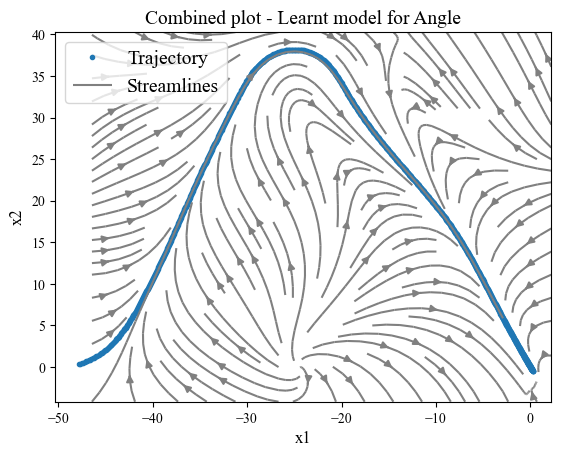

In [156]:
fig_learntmodel = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps")

### Random Features Vanishing on a Point Set

In [157]:
def phi_function(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    psi = capital_psi(x, w, b, m, dim)
    phi[dim*0] = psi[0]
    phi[dim*0+1] = psi[1]
    return phi

def capital_psi_z_function(x, w, b, m, dim, L):
    psi = capital_psi(x, w, b, m, dim)
    return L.T @ psi.T

def capital_phi_z_function(x, w, b, n, m, dim, L):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi_z_function(x[:,i], w, b, m, dim, L)
        phi[dim*i] = psi.T[0]
        phi[dim*i+1] = psi.T[1]
    return phi

In [158]:
def alpha_approx_function(x_vector, y, dim, m, lam, n, L):
    phi_ = capital_phi_z_function(x_vector, w, b, n, m, dim, L)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    #alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_param', (m_param*dim_param, 1))
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    #alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

### Alpha with contraction constraint using analytical Jacobian

In [ ]:
def alpha_approx_with_constraint_function(x_vector, y, dim, m, lam, n, mu, contraction_points, L):
    phi_ = capital_phi_z_function(x_vector, w, b, n, m, dim, L)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    mu_param = pc.Constant('mu', mu)
    constraint_points = pc.Constant('const_points', contraction_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (m_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points):
        x = x_vector[:, i*4]
        gradient = np.zeros(dim)
        for j in range(m):
            index = 2*j
            psi_derivative_param = pc.Constant('psi_derivative', psi_derivative(x, w[:, j], b[:, j]))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

### Finding vanishing point

In [159]:
x_vanish = x_train[:,-1]
num_of_vanish_points = np.size(x_vanish[0])

capital_phi_z = phi_function(x_vanish, w, b, num_of_vanish_points, num_of_samples, dim_of_function)

# Calculate P_Psi = LL^T as done by Sindhwani
capital_phi_z = capital_phi_z.T
P_Psi = capital_phi_z @ np.linalg.solve((capital_phi_z.T @ capital_phi_z), capital_phi_z.T)
P_Psi = np.eye(P_Psi[0].size) - P_Psi

# Fix symmetry of matrix and buffer against numerical noise
P_Psi = (P_Psi + P_Psi.T) / 2 + (np.eye(P_Psi[0].size)*1e-12)

L_ = np.linalg.cholesky(P_Psi)
#P_Psi_L = L @ L.T

alpha = alpha_approx_with_constraint_function(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_contraction_points, L_)
#alpha = alpha_approx_function(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points, L_)

C:\Users\Heli\AppData\Local\Temp\ipykernel_5552\3708733681.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


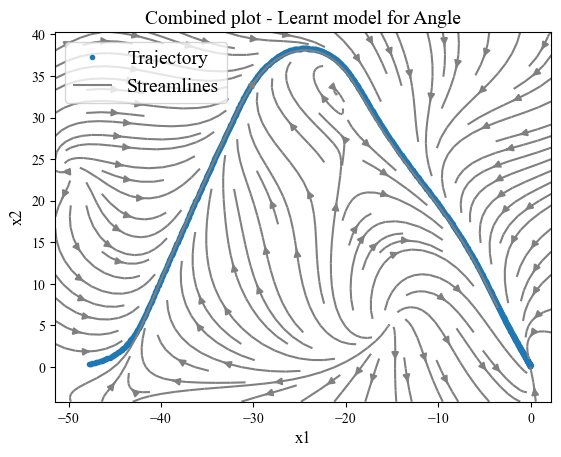

In [162]:
alpha_array_rff = alpha

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi_z_function(x, w, b, num_of_samples, dim_of_function, L_).T @ alpha_array_rff
    return func

timespan = np.array([time_series[0],time_series[-1]])
t = np.linspace(time_series[0],time_series[-1], 1000)
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval = t).y

# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1-5, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

t = 0
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

for (i,j), value in np.ndenumerate(X1):

    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

fig_learntmodel = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps")

### Make symbolic function for jacobian of f

In [164]:
x = sym.MatrixSymbol('x', size_of_state, 1)
a = sym.MatrixSymbol('a', np.size(P_Psi[1]), 1) # Placeholder for alpha
psi_vector = sym.MatrixSymbol('psi_vector', num_of_samples, 1)

eq = psi_vector(i)
# sym.Mul(sym.sqrt(2), sym.cos(w.T@x + b))


In [ ]:
def alpha_approx_with_constraint_symbolic(x_vector, y, dim, m, lam, n, mu, contraction_points, L):
    phi_ = capital_phi_z_function(x_vector, w, b, n, m, dim, L)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    m_param = pc.Constant('m', m)
    mu_param = pc.Constant('mu', mu)
    constraint_points = pc.Constant('const_points', contraction_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (m_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points):
        x = x_vector[:, i*4]
        gradient = np.zeros(dim)
        for j in range(m):
            index = 2*j
            psi_derivative_param = pc.Constant('psi_derivative', psi_derivative(x, w[:, j], b[:, j]))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var